# –í—ã–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ —Ç–∞–±–ª–∏—Ü –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ –¥–ª—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ—Å—Ç–æ–≤ –≤ —Å–æ—Ü–∏–∞–ª—å–Ω–æ–π —Å–µ—Ç–∏ Karpov Courses.
–ù–æ—É—Ç–±—É–∫ –≤—ã–ø–æ–ª–Ω—è–ª—Å—è –≤ kaggle.

In [1]:
!pip install psycopg2-binary

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3.0/3.0 MB 28.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.utils import shuffle

import re
import string

from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sys
import gc

from dotenv import load_dotenv
import os

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–æ—Å—Ç—É–ø—ã –∫ –±–∞–∑–µ –¥–∞–Ω–Ω—ã—Ö —Å–æ—Ü–∞–ª—å–Ω–æ–π —Å–µ—Ç–∏ Karpov Courses
load_dotenv(r'/kaggle/input/karpov-startml-db/env')

True

In [6]:
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRES_PASSWORD = os.environ['POSTGRES_PASSWORD']
POSTGRES_HOST = os.environ['POSTGRES_HOST']
POSTGRES_PORT = os.environ['POSTGRES_PORT']
POSTGRES_DATABASE = os.environ['POSTGRES_DATABASE']

In [7]:
str_con_db = f'postgresql://{POSTGRESUSER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}'

In [8]:
engine = create_engine(str_con_db)

In [9]:
def load_feed_data(CHUNKSIZE: int = 1000000, limit:int = 1000, engine=engine) -> pd.DataFrame:
    """–í—ã–≥—Ä—É–∑–∫–∞ —Ç–∞–±–ª–∏—Ü—ã feed_data, –ø–æ —á–∞–Ω–∫–∞–º."""
    sql_text = "SELECT timestamp, user_id, post_id, target \
            FROM public.feed_data \
            WHERE action='view' \
            ORDER BY user_id, timestamp LIMIT {};"
    
    chunks = []
    conn = engine.connect().execution_options(stream_results=True)
    
    for indx, chunk_dataframe in enumerate(pd.read_sql(sql_text.format(limit), con=conn, chunksize=CHUNKSIZE)):
        chunks.append(chunk_dataframe)
        print(f'{indx} –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º {CHUNKSIZE}')
    
    conn.close()
    all_chunks = pd.concat(chunks, ignore_index=True)
    
    return all_chunks

In [10]:
def batch_load_sql(query: str, CHUNKSIZE: int = 1000000, engine=engine) -> pd.DataFrame:
    """–í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ sql-–∑–∞–ø—Ä–æ—Å–∞ query –∏ –≤—ã–≥—Ä—É–∑–∫–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞, –ø–æ —á–∞–Ω–∫–∞–º."""
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

# –¢–∞–±–ª–∏—Ü–∞ —Å –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º–∏.

In [11]:
user_info = pd.read_sql("""SELECT * FROM public.user_data""", con=engine)
user_info.head()

user_id  gender  age country               city  exp_group       os source
0      200       1   34  Russia          Degtyarsk          3  Android    ads
1      201       0   37  Russia             Abakan          0  Android    ads
2      202       1   17  Russia           Smolensk          4  Android    ads
3      203       0   18  Russia             Moscow          1      iOS    ads
4      204       0   36  Russia  Anzhero-Sudzhensk          3  Android    ads

In [12]:
user_info.shape

(163205, 8)

–í—Å–µ–≥–æ 163205 –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π.

# –¢–∞–±–ª–∏—Ü–∞ —Å –ø–æ—Å—Ç–∞–º–∏.

In [13]:
posts_info = pd.read_sql("""SELECT * FROM public.post_text_df""", con=engine)
posts_info.head()

post_id                                               text     topic
0        1  UK economy facing major risks\n\nThe UK manufa...  business
1        2  Aids and climate top Davos agenda\n\nClimate c...  business
2        3  Asian quake hits European shares\n\nShares in ...  business
3        4  India power shares jump on debut\n\nShares in ...  business
4        5  Lacroix label bought by US firm\n\nLuxury good...  business

In [14]:
posts_info.shape

(7023, 3)

7023 –ø–æ—Å—Ç–æ–≤.

# –¢–∞–±–ª–∏—Ü–∞ feed_data

–¢–∞–±–ª–∏—Ü–∞ –æ—á–µ–Ω—å –±–æ–ª—å—à–∞—è, –≤—ã–≥—Ä—É–∑–∫–∞ –≤—Å–µ–π —Ç–∞–±–ª–∏—Ü—ã –ø—Ä–∏–≤–µ–¥—ë—Ç –∫ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é –≤—Å–µ–π –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ–π –ø–∞–º—è—Ç–∏ –∏ –ø–∞–¥–µ–Ω–∏—é —è–¥—Ä–∞.

In [15]:
count_feed_data = pd.read_sql("""SELECT count(*) FROM public.feed_data""", con=engine)
count_feed_data.head()

count
0  76892800

–í —Ç–∞–±–ª–∏—Ü–µ –±–æ–ª–µ–µ 76 –º–∏–ª–ª–∏–æ–Ω–æ–≤ –∑–∞–ø–∏—Å–µ–π.

–¢–∞–±–ª–∏—Ü–∞ feed_data —è–≤–ª—è–µ—Ç—Å—è –æ—Å–Ω–æ–≤–Ω–æ–π —Ç–∞–±–ª–∏—Ü–µ–π –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ –ø–æ—Å—Ç–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –ª–∞–π–∫–∞—é—Ç –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏. –ò–∑ —É—Å–ª–æ–≤–∏–π –∑–∞–¥–∞—á–∏ –≤–∞–∂–Ω—ã –ø–æ—Å—Ç—ã —É –∫–æ—Ç–æ—Ä—ã—Ö –≤ –ø–æ–ª–µ action == 'view' –∏ –ø–æ–ª–µ target == 1. –ó–∞–≥—Ä—É–∑–∏–º 10_000_000 –∑–∞–ø–∏—Å–µ–π —ç—Ç–æ–π —Ç–∞–±–ª–∏—Ü—ã, –≥–¥–µ action == 'view', –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Å–ø–µ—Ü–∏–∞–ª—å–Ω—É—é —Ñ—É–Ω–∫—Ü–∏—é, –∫–æ—Ç–æ—Ä–∞—è –∑–∞–≥—Ä—É–∂–∞–µ—Ç –¥–∞–Ω–Ω—ã–µ —á–∞—Å—Ç—è–º–∏, –ø–æ —á–∞–Ω–∫–∞–º, —Ç.–∫. —Ñ—É–Ω–∫—Ü–∏—è pd.read_sql –ø—Ä–∏ –∑–∞–≥—Ä—É–∑–∫–µ –¥–∞–Ω–Ω—ã—Ö –ø–æ—Ç—Ä–µ–±–ª—è–µ—Ç –≤ 4 —Ä–∞–∑–∞ –±–æ–ª—å—à–µ –ø–∞–º—è—Ç–∏.

In [16]:
feed_data_chunk = load_feed_data(limit = 10_000_000)

0 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
1 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
2 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
3 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
4 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
5 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
6 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
7 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
8 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000
9 –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ —á–∞–Ω–∫–∞–º 1000000


In [17]:
feed_data_chunk.target.value_counts()

0    8804157
1    1195843
Name: target, dtype: int64

–í—ã–±–æ—Ä–∫–∞ –Ω–µ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–∞. –ë–æ–ª—å—à–µ –¥–∞–Ω–Ω—ã—Ö —Å target == 0. –°–¥–µ–ª–∞–µ–º –≤—ã–±–æ—Ä–∫—É —Å –ø—Ä–∏–º–µ—Ä–Ω–æ —Ä–∞–≤–Ω—ã–º –∫–æ–ª-–≤–æ–º target.

In [18]:
feed_data_1 = feed_data_chunk[feed_data_chunk.target == 1]
feed_data_0 = feed_data_chunk[feed_data_chunk.target == 0]

In [19]:
feed_data_0.shape

(8804157, 4)

In [20]:
# –í—ã–∫–∏–Ω–µ–º —á–∞—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö —Å target == 0
frac =  feed_data_1.shape[0] / feed_data_0.shape[0] + 0.001
feed_data_0_lim = feed_data_0.sample(frac=frac)
feed_data_0_lim.shape

(1204647, 4)

In [21]:
# –û–±—ä–µ–¥–∏–Ω–∏–º –¥–≤–µ –≤—ã–±–æ—Ä–∫–∏ —Å target == 1 –∏ target == 0 –∏ –ø–µ—Ä–µ–º–µ—à–∞–µ–º
feed_data_new = pd.concat([feed_data_0_lim, feed_data_1])
feed_data_new = shuffle(feed_data_new, random_state=0)

In [22]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å –≤—ã–±–æ—Ä–∫–∏ –ø—Ä–∏ –µ—ë —Ä–∞–∑–ª–∏—á–Ω–æ–º –∫–æ–ª-–≤–µ 
feed_data_new.iloc[:100].target.value_counts()

0    51
1    49
Name: target, dtype: int64

In [23]:
feed_data_new.iloc[:1000].target.value_counts()

1    511
0    489
Name: target, dtype: int64

In [24]:
feed_data_new.iloc[:100000].target.value_counts()

0    50106
1    49894
Name: target, dtype: int64

In [25]:
feed_data_new.iloc[:1000000].target.value_counts()

0    501702
1    498298
Name: target, dtype: int64

In [26]:
feed_data_new.iloc[:10000000].target.value_counts()

0    1204647
1    1195843
Name: target, dtype: int64

In [27]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –≤—ã–±–æ—Ä–∫—É –≤ csv-—Ñ–∞–π–ª.
feed_data_new.to_csv('feed_data.csv', index=False)

In [28]:
# –û—á–∏—â–∞–µ–º –ø–∞–º—è—Ç—å
del feed_data_new, feed_data_chunk, feed_data_1, feed_data_0, feed_data_0_lim
gc.collect()

42

# –í—ã–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π.

In [29]:
user_info.head()

user_id  gender  age country               city  exp_group       os source
0      200       1   34  Russia          Degtyarsk          3  Android    ads
1      201       0   37  Russia             Abakan          0  Android    ads
2      202       1   17  Russia           Smolensk          4  Android    ads
3      203       0   18  Russia             Moscow          1      iOS    ads
4      204       0   36  Russia  Anzhero-Sudzhensk          3  Android    ads

–û—á–µ–≤–∏–¥–Ω–æ, —á—Ç–æ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏–µ –ø–æ—Å—Ç–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –Ω–µ –∑–∞–≤–∏—Å—è—Ç –æ—Ç —Ç–æ–≥–æ –∫–∞–∫–∞—è –æ–ø–µ—Ä–∞—Ü–∏–æ–Ω–Ω–∞—è —Å–∏—Å—Ç–µ–º–∞ –Ω–∞ –µ–≥–æ —É—Å—Ç—Ä–æ–π—Å—Ç–≤–µ –∏ —Å –∫–∞–∫–æ–≥–æ —Ä–µ—Å—É—Ä—Å–∞ –æ–Ω –ø—Ä–∏—à—ë–ª. –£–¥–∞–ª–∏–º —ç—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏.

In [30]:
user_info_data = user_info.drop(['os', 'source'], axis=1)

–í—ã–¥–µ–ª–∏–º –Ω–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π. –î–æ–±–∞–≤–∏–º –∫–æ–ª–æ–Ω–∫–∏ —Å–æ —Å—Ä–µ–¥–Ω–∏–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –ª–∞–π–∫–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è, –∫–∞–∂–¥–æ–≥–æ —Ç–æ–ø–∏–∫–∞ –ø–æ—Å—Ç–∞. –¢.–µ. –¥–æ–ª—è –ª–∞–π–∫–Ω—É—Ç—ã—Ö –ø–æ—Å—Ç–æ–≤ –≤ –∫–∞–∂–¥–æ–º —Ç–æ–ø–∏–∫–µ, –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è. –í—ã–ø–æ—Ä–ª–Ω–∏–º SQL –∑–∞–ø—Ä–æ—Å–æ–º –∫ –ë–î.

In [31]:
sql_text = "SELECT public.feed_data.user_id, public.post_text_df.topic, avg(public.feed_data.target) \
            FROM public.feed_data \
            JOIN public.post_text_df ON public.feed_data.post_id=public.post_text_df.post_id \
            WHERE public.feed_data.action='view' \
            GROUP BY public.feed_data.user_id, public.post_text_df.topic;"

In [32]:
user_like = batch_load_sql(sql_text)

In [33]:
user_like

user_id          topic       avg
0            200       business  0.071429
1            200          covid  0.096774
2            200  entertainment  0.285714
3            200          movie  0.170455
4            200       politics  0.068966
...          ...            ...       ...
1142350   168552  entertainment  0.000000
1142351   168552          movie  0.039216
1142352   168552       politics  0.000000
1142353   168552          sport  0.185185
1142354   168552           tech  0.000000

[1142355 rows x 3 columns]

–ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—É—é —Ç–∞–±–ª–∏—Ü—É –≤ –±–æ–ª–µ–µ —É–¥–æ–±–Ω—ã–π —Ñ–æ—Ä–º–∞—Ç.

In [34]:
user_like = user_like.pivot_table('avg', index='user_id', columns='topic')

In [35]:
user_like

topic    business     covid  entertainment     movie  politics     sport  \
user_id                                                                    
200      0.071429  0.096774       0.285714  0.170455  0.068966  0.109375   
201      0.103448  0.063953       0.121212  0.122677  0.013889  0.023256   
202      0.052632  0.139241       0.037037  0.126812  0.254237  0.168831   
203      0.157895  0.183099       0.181818  0.182482  0.200000  0.224490   
204      0.125000  0.258065       0.200000  0.140625  0.100000  0.117647   
...           ...       ...            ...       ...       ...       ...   
168548   0.083333  0.072289       0.105263  0.047945  0.025641  0.000000   
168549   0.000000  0.074627       0.000000  0.063158  0.225806  0.160000   
168550   0.034483  0.117647       0.086957  0.135802  0.000000  0.030303   
168551   0.047619  0.131148       0.176471  0.110000  0.026316  0.062500   
168552   0.000000  0.060606       0.000000  0.039216  0.000000  0.185185   

topic        tech  
user_id            
200      0.153846  
201      0.137931  
202      0.000000  
203      0.222222  
204      0.333333  
...           ...  
168548   0.250000  
168549   0.000000  
168550   0.142857  
168551   0.066667  
168552   0.000000  

[163205 rows x 7 columns]

In [36]:
user_like.columns.name = None
user_like = user_like.reset_index()

In [37]:
user_like

user_id  business     covid  entertainment     movie  politics  \
0           200  0.071429  0.096774       0.285714  0.170455  0.068966   
1           201  0.103448  0.063953       0.121212  0.122677  0.013889   
2           202  0.052632  0.139241       0.037037  0.126812  0.254237   
3           203  0.157895  0.183099       0.181818  0.182482  0.200000   
4           204  0.125000  0.258065       0.200000  0.140625  0.100000   
...         ...       ...       ...            ...       ...       ...   
163200   168548  0.083333  0.072289       0.105263  0.047945  0.025641   
163201   168549  0.000000  0.074627       0.000000  0.063158  0.225806   
163202   168550  0.034483  0.117647       0.086957  0.135802  0.000000   
163203   168551  0.047619  0.131148       0.176471  0.110000  0.026316   
163204   168552  0.000000  0.060606       0.000000  0.039216  0.000000   

           sport      tech  
0       0.109375  0.153846  
1       0.023256  0.137931  
2       0.168831  0.000000  
3       0.224490  0.222222  
4       0.117647  0.333333  
...          ...       ...  
163200  0.000000  0.250000  
163201  0.160000  0.000000  
163202  0.030303  0.142857  
163203  0.062500  0.066667  
163204  0.185185  0.000000  

[163205 rows x 8 columns]

–î–∞–Ω–Ω–∞—è —Ç–∞–±–ª–∏—Ü–∞ —Å–æ–¥–µ—Ä–∂–∏—Ç –∑–Ω–∞—á–µ–Ω–∏—è nan. –û–Ω–∏ –ø–æ—è–≤–∏–ª–∏—Å—å –∏–∑-–∑–∞ —Ç–æ–≥–æ, —á—Ç–æ –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –ø—Ä–æ—Å—Ç–æ –Ω–µ —Å–º–æ—Ç—Ä–µ–ª–∏, –Ω–µ –∏–Ω—Ç–µ—Ä–µ—Å–æ–≤–∞–ª–∏—Å—å –ø–æ—Å—Ç–∞–º–∏ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—ã—Ö —Ç–æ–ø–∏–∫–æ–≤.

In [38]:
user_like.isna().sum()

user_id           0
business          6
covid             0
entertainment    20
movie             0
politics          0
sport             0
tech             54
dtype: int64

In [39]:
# –ó–∞–ø–æ–ª–Ω–∏–º nan –Ω—É–ª—ë–º
user_like.fillna(value=0, inplace=True)

In [40]:
user_like.isna().sum()

user_id          0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

In [41]:
# –û–±—ä–µ–¥–∏–Ω–∏–º –ø–æ–ª—É—á–µ–Ω–Ω—É—é —Ç–∞–±–ª–∏—Ü—É —Å —Ç–∞–±–ª–∏—Ü–µ–π –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π
user_info_data = user_info_data.merge(user_like, left_on='user_id', right_on='user_id')

In [42]:
user_info_data

user_id  gender  age country               city  exp_group  business  \
0           200       1   34  Russia          Degtyarsk          3  0.071429   
1           201       0   37  Russia             Abakan          0  0.103448   
2           202       1   17  Russia           Smolensk          4  0.052632   
3           203       0   18  Russia             Moscow          1  0.157895   
4           204       0   36  Russia  Anzhero-Sudzhensk          3  0.125000   
...         ...     ...  ...     ...                ...        ...       ...   
163200   168548       0   36  Russia        Kaliningrad          4  0.083333   
163201   168549       0   18  Russia               Tula          2  0.000000   
163202   168550       1   41  Russia      Yekaterinburg          4  0.034483   
163203   168551       0   38  Russia             Moscow          3  0.047619   
163204   168552       1   16  Russia        Ivanteyevka          4  0.000000   

           covid  entertainment     movie  politics     sport      tech  
0       0.096774       0.285714  0.170455  0.068966  0.109375  0.153846  
1       0.063953       0.121212  0.122677  0.013889  0.023256  0.137931  
2       0.139241       0.037037  0.126812  0.254237  0.168831  0.000000  
3       0.183099       0.181818  0.182482  0.200000  0.224490  0.222222  
4       0.258065       0.200000  0.140625  0.100000  0.117647  0.333333  
...          ...            ...       ...       ...       ...       ...  
163200  0.072289       0.105263  0.047945  0.025641  0.000000  0.250000  
163201  0.074627       0.000000  0.063158  0.225806  0.160000  0.000000  
163202  0.117647       0.086957  0.135802  0.000000  0.030303  0.142857  
163203  0.131148       0.176471  0.110000  0.026316  0.062500  0.066667  
163204  0.060606       0.000000  0.039216  0.000000  0.185185  0.000000  

[163205 rows x 13 columns]

In [43]:
# –ï—â—ë —Ä–∞–∑ –ø—Ä–æ–≤–µ—Ä–∏–º –Ω–∞ –ø—É—Å—Ç—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
user_info_data.isna().sum()

user_id          0
gender           0
age              0
country          0
city             0
exp_group        0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

–ü—Ä–æ–≤–µ—Ä–∏–º –Ω–µ—Ç –ª–∏ –ª–∏–Ω–µ–π–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –Ω–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π.

<AxesSubplot:>

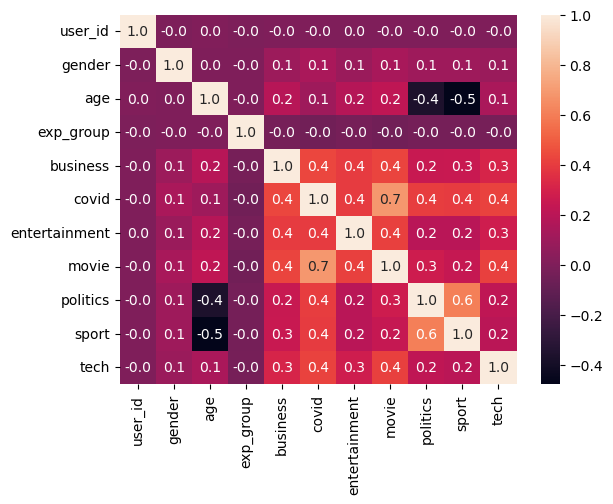

In [44]:
sns.heatmap(user_info_data.corr(method='pearson'), annot=True, fmt=".1f")

–ï—Å—Ç—å –∑–∞–º–µ—Ç–Ω–∞—è –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å –º–µ–∂–¥—É covid –∏ movie. –ò –º–µ–∂–¥—É politics –∏ sport. –¢–∞–∫–∂–µ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É–µ—Ç —É–º–µ—Ä–µ–Ω–Ω–∞—è –æ–±—Ä–∞—Ç–Ω–∞—è –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å –º–µ–∂–¥—É age –∏ sport. –ò –µ—Å—Ç—å –¥–æ–≤–æ–ª—å–Ω–æ –º–Ω–æ–≥–æ —É–º–µ—Ä–µ–Ω–Ω—ã—Ö –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–µ–π –º–µ–∂–¥—É –Ω–æ–≤—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏. –£–∂–µ –ø–æ —ç—Ç–∏–º –Ω–æ–≤—ã–º –¥–∞–Ω–Ω—ã–º –º–æ–∂–Ω–æ —Å–æ—Å—Ç–∞–≤–∏—Ç—å –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω—É—é –∫–∞—Ä—Ç–∏–Ω—É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π. –ù–∞–ø—Ä–∏–º–µ—Ä, —Ç–µ –∫–æ–º—É –Ω—Ä–∞–≤—è—Ç—Å—è –ø–æ—Å—Ç—ã –ø–æ —Ç–µ–º–µ –ø–æ–ª–∏—Ç–∏–∫–∏, –æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ –ø—Ä–µ–¥–ø–æ—á—Ç—É—Ç –ø–æ—Å—Ç—ã –ø–æ —Å–ø–æ—Ä—Ç—É.

–ó–∞–ø–∏—à–µ–º —Ç–∞–±–ª–∏—Ü—É –≤ –ë–î.

In [45]:
user_info_data.to_sql('pavel55645_users_lesson_22', con=engine, if_exists='replace')

# –¢–∞–±–ª–∏—Ü–∞ —Å –ø–æ—Å—Ç–∞–º–∏. –í—ã–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ—Å—Ç–æ–≤.

In [46]:
posts_info.head()

post_id                                               text     topic
0        1  UK economy facing major risks\n\nThe UK manufa...  business
1        2  Aids and climate top Davos agenda\n\nClimate c...  business
2        3  Asian quake hits European shares\n\nShares in ...  business
3        4  India power shares jump on debut\n\nShares in ...  business
4        5  Lacroix label bought by US firm\n\nLuxury good...  business

–í—ã–ø–æ–ª–Ω–∏–º –ª–µ–º–∞—Ç–∏–∑–∞—Ü–∏—é –ø–æ—Å—Ç–æ–≤ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ tfidf.

In [47]:
wnl = WordNetLemmatizer()

def preprocessing(line: str, token=wnl) -> str:
    line = line.lower()
    line = re.sub(r'[{}]'.format(string.punctuation), ' ', line)
    line = line.replace(r'\n\n', ' ').replace(r'\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

tfidf = TfidfVectorizer(stop_words='english', preprocessor=preprocessing)

In [48]:
tfidf_data = tfidf.fit_transform(posts_info['text']).toarray()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [49]:
tfidf_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13279494, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05136483, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [50]:
tfidf_data = pd.DataFrame(tfidf_data, index=posts_info.post_id, columns=tfidf.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
tfidf_data

00       000  0001  000bn  000m  000s  000th  001  001and  001st  \
post_id                                                                      
1        0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
2        0.0  0.132795   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
3        0.0  0.051365   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
4        0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
5        0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
...      ...       ...   ...    ...   ...   ...    ...  ...     ...    ...   
7315     0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
7316     0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
7317     0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
7318     0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   
7319     0.0  0.000000   0.0    0.0   0.0   0.0    0.0  0.0     0.0    0.0   

         ...   ùì´ùìÆ  ùì´ùìÆùìΩùìΩùìÆùìª  ùì¨ùì∏ùìæùìªùìΩùìº  ùì±ùìÆùì™ùìªùì≤ùì∑ùì∞  ùì∂ùì™ùîÇ  ùìπùì±ùîÇùìºùì≤ùì¨ùì™ùìµ  ùìºùì∏ùì∏ùì∑ùìÆùìª  \
post_id  ...                                                        
1        ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
2        ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
3        ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
4        ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
5        ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
...      ...  ...     ...     ...      ...  ...       ...     ...   
7315     ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
7316     ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
7317     ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
7318     ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   
7319     ...  0.0     0.0     0.0      0.0  0.0       0.0     0.0   

         ùìºùìæùì´ùì∏ùìªùì≠ùì≤ùì∑ùì™ùìΩùìÆ  ùìΩùì±ùìÆ   ùìΩùì∏  
post_id                         
1                0.0  0.0  0.0  
2                0.0  0.0  0.0  
3                0.0  0.0  0.0  
4                0.0  0.0  0.0  
5                0.0  0.0  0.0  
...              ...  ...  ...  
7315             0.0  0.0  0.0  
7316             0.0  0.0  0.0  
7317             0.0  0.0  0.0  
7318             0.0  0.0  0.0  
7319             0.0  0.0  0.0  

[7023 rows x 46493 columns]

–ü–æ–ª—É—á–∏–ª–æ—Å—å —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤. –ë—É–¥–µ–º –ø–æ–Ω–∏–∂–∞—Ç—å —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –∏ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–æ–≤–∞—Ç—å –ø–æ—Å—Ç—ã.

In [52]:
posts_info_data = posts_info

In [53]:
# –°–æ–∑–¥–∞–¥–∏–º –Ω–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ—Å—Ç–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ TfIdf
posts_info_data['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info_data['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info_data['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

In [54]:
posts_info_data.head()

post_id                                               text     topic  \
0        1  UK economy facing major risks\n\nThe UK manufa...  business   
1        2  Aids and climate top Davos agenda\n\nClimate c...  business   
2        3  Asian quake hits European shares\n\nShares in ...  business   
3        4  India power shares jump on debut\n\nShares in ...  business   
4        5  Lacroix label bought by US firm\n\nLuxury good...  business   

   TotalTfIdf  MaxTfIdf  MeanTfIdf  
0    8.796359  0.494083   0.000189  
1   11.909230  0.308132   0.000256  
2   12.935175  0.200614   0.000278  
3    6.714893  0.542900   0.000144  
4    6.352120  0.420250   0.000137

–ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º —Ç–µ–∫—Å—Ç—ã. –î–ª—è –Ω–∞—á–∞–ª–∞, –ø—Ä–∏ –ø–æ–º–æ—â–∏ PCA –ø–æ–Ω–∏–∑–∏–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ tfidf

In [55]:
# –¶–µ–Ω—Ç—Ä—É–µ–º –∑–Ω–∞—á–µ–Ω–∏—è tfidf
centered = tfidf_data - tfidf_data.mean()

In [56]:
del tfidf_data
gc.collect()

141

In [57]:
# –ü–æ–Ω–∏–∂–∞–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

In [58]:
# –†–∞–∑–¥–µ–ª–∏–º —Ç–µ–∫—Å—Ç—ã –ø–æ—Å—Ç–æ–≤ –Ω–∞ 15 –∫–ª–∞—Å—Ç–µ—Ä–æ–≤, –ø—Ä–∏ –ø–æ–º–æ—â–∏ –º–µ—Ç–æ–¥–∞ –∫-—Å—Ä–µ–¥–Ω–∏—Ö. –ò –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–æ—Å—Ç–∞ –≤—ã—á–∏—Å–ª–∏–º —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–∞.
n_clusters = 15

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

# –î–æ–±–∞–≤–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫ –º–µ—Ç–∫–∞ –∫–ª–∞—Å—Ç–µ—Ä–∞, –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–æ—Å—Ç–∞.
posts_info_data['TextCluster'] = kmeans.labels_

dists_columns = [f"DistanceTo{ith}thCluster" for ith in range(1, n_clusters + 1)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

DistanceTo1thCluster  DistanceTo2thCluster  DistanceTo3thCluster  \
0              0.439563              0.476647              0.525989   
1              0.291927              0.341049              0.413877   
2              0.306652              0.355077              0.427654   
3              0.258363              0.316523              0.382000   
4              0.177380              0.258599              0.343021   

   DistanceTo4thCluster  DistanceTo5thCluster  DistanceTo6thCluster  \
0              0.577732              0.448398              0.133566   
1              0.332242              0.308124              0.270574   
2              0.527312              0.326345              0.136852   
3              0.486955              0.270908              0.240676   
4              0.456168              0.194749              0.301233   

   DistanceTo7thCluster  DistanceTo8thCluster  DistanceTo9thCluster  \
0              0.454774              0.491698              0.384825   
1              0.292754              0.363830              0.194770   
2              0.334820              0.382879              0.206098   
3              0.280283              0.313666              0.126942   
4              0.238320              0.284530              0.065982   

   DistanceTo10thCluster  DistanceTo11thCluster  DistanceTo12thCluster  \
0               0.455664               0.528264               0.499950   
1               0.321931               0.420314               0.374802   
2               0.335009               0.439116               0.382722   
3               0.304548               0.406651               0.348495   
4               0.238080               0.398268               0.295108   

   DistanceTo13thCluster  DistanceTo14thCluster  DistanceTo15thCluster  
0               0.543205               0.457611               0.427875  
1               0.440154               0.307152               0.169212  
2               0.471314               0.355046               0.327838  
3               0.436034               0.317959               0.260532  
4               0.396876               0.277128               0.219711

In [59]:
# –û–±—ä–µ–¥–∏–Ω–∏–º –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ—Å—Ç–æ–≤.
posts_info_data = pd.concat((posts_info_data,dists_df), axis=1)
posts_info_data.head()

post_id                                               text     topic  \
0        1  UK economy facing major risks\n\nThe UK manufa...  business   
1        2  Aids and climate top Davos agenda\n\nClimate c...  business   
2        3  Asian quake hits European shares\n\nShares in ...  business   
3        4  India power shares jump on debut\n\nShares in ...  business   
4        5  Lacroix label bought by US firm\n\nLuxury good...  business   

   TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
0    8.796359  0.494083   0.000189            5              0.439563   
1   11.909230  0.308132   0.000256           14              0.291927   
2   12.935175  0.200614   0.000278            5              0.306652   
3    6.714893  0.542900   0.000144            8              0.258363   
4    6.352120  0.420250   0.000137            8              0.177380   

   DistanceTo2thCluster  DistanceTo3thCluster  ...  DistanceTo6thCluster  \
0              0.476647              0.525989  ...              0.133566   
1              0.341049              0.413877  ...              0.270574   
2              0.355077              0.427654  ...              0.136852   
3              0.316523              0.382000  ...              0.240676   
4              0.258599              0.343021  ...              0.301233   

   DistanceTo7thCluster  DistanceTo8thCluster  DistanceTo9thCluster  \
0              0.454774              0.491698              0.384825   
1              0.292754              0.363830              0.194770   
2              0.334820              0.382879              0.206098   
3              0.280283              0.313666              0.126942   
4              0.238320              0.284530              0.065982   

   DistanceTo10thCluster  DistanceTo11thCluster  DistanceTo12thCluster  \
0               0.455664               0.528264               0.499950   
1               0.321931               0.420314               0.374802   
2               0.335009               0.439116               0.382722   
3               0.304548               0.406651               0.348495   
4               0.238080               0.398268               0.295108   

   DistanceTo13thCluster  DistanceTo14thCluster  DistanceTo15thCluster  
0               0.543205               0.457611               0.427875  
1               0.440154               0.307152               0.169212  
2               0.471314               0.355046               0.327838  
3               0.436034               0.317959               0.260532  
4               0.396876               0.277128               0.219711  

[5 rows x 22 columns]

In [60]:
# –ó–∞–ø–∏—à–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ—Å—Ç–æ–≤ –≤ —Ç–∞–±–ª–∏—Ü—É –ë–î.
posts_info_data.to_sql('pavel55645_posts_info_lesson_22', con=engine, if_exists='replace')

–í –∏—Ç–æ–≥–µ –∏–º–µ–µ–º –≤—ã–≥—Ä—É–∑–∫—É –¥–∞–Ω–Ω—ã—Ö —Å —Ç–∞–±–ª–∏—Ü—ã feed_data –∏ —Ç–∞–±–ª–∏—Ü—ã —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ –ø–æ—Å—Ç–æ–≤, –º–æ–∂–Ω–æ –æ–±—É—á–∞—Ç—å –º–æ–¥–µ–ª–∏.